# Real-time AI Stock Prediction Model for CSE

This notebook implements a complete Machine Learning pipeline using realistic mock data to demonstrate the workflow.
Because the unofficial API often returns errors without proper session handling, we use a mock client for demonstration.

## Pipeline Steps:
1. **Problem Definition**: Predict if a stock price will close HIGHER or LOWER on the next trading day.
2. **Data Collection**: Fetch data using the `cse_mock_client`.
3. **Preprocessing**: Clean data, handle missing values.
4. **Feature Engineering**: Create technical indicators (RSI, SMA, Volatility).
5. **EDA**: Visualize trends and correlations.
6. **Modeling**: Train a Random Forest Classifier.
7. **Evaluation**: Assess performance with accuracy and classification reports.
8. **Real-time Prediction**: A function to fetch current data and predict the next move.

## 1. Setup and Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Ensure local imports work
sys.path.append(os.getcwd())

try:
    from cse_mock_client import CSEClient
    print("Using CSE Mock Client for demonstration.")
except ImportError:
    # Fallback if mock client file is missing
    from cse_client import CSEClient
    print("Using standard CSE Client.")

# ML Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('whitegrid')

Using CSE Mock Client for demonstration.


## 2. Data Collection

In [30]:
client = CSEClient()

def fetch_stock_data(symbol):
    print(f"Fetching data for {symbol}...")
    data = client.get_chart_data(symbol)
    
    if not data or 'reqTradeSummery' not in data or 'chartData' not in data['reqTradeSummery']:
         print("No data found or invalid response.")
         return None
    
    chart_data = data['reqTradeSummery']['chartData']
    
    # Convert to DataFrame
    df = pd.DataFrame(chart_data)
    
    # Rename columns to standard names
    # Based on API: t=time, p=price(close?), o=open, h=high, l=low, c=change?
    # We'll assume 'p' is the close price for that interval.
    df.rename(columns={'t': 'Timestamp', 'p': 'Close', 'h': 'High', 'l': 'Low', 'o': 'Open', 'v': 'Volume'}, inplace=True)
    
    # Convert Timestamp (ms) to datetime
    df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df.set_index('Date', inplace=True)
    
    # Drop API specific cols we might not need
    df = df[['Close', 'High', 'Low', 'Open']]
    
    # Handle missing Open prices (sometimes API returns None for Open)
    # We can fill Open with the previous Close as a proxy
    df['Open'] = df['Open'].fillna(df['Close'].shift(1))
    df['Open'] = df['Open'].fillna(df['Close']) # For the first row
    
    return df

# Fetch sample data (e.g., John Keells Holdings)
SYMBOL = 'JKH.N0000'
df = fetch_stock_data(SYMBOL)

if df is not None:
    print(f"Loaded {len(df)} data points.")
    display(df.head())
else:
    print("Failed to load data.")

Fetching data for JKH.N0000...
Loaded 365 data points.


,Close,High,Low,Open
Date,,,,
2025-02-07 18:07:58.206,149.97,152.02,149.61,150.81
2025-02-08 18:07:58.206,150.31,151.13,149.61,150.37
2025-02-09 18:07:58.206,151.41,153.76,149.06,151.41
2025-02-10 18:07:58.206,152.64,152.89,150.17,151.53
2025-02-11 18:07:58.206,152.55,155.12,149.75,152.44


## 3. Data Preprocessing & Feature Engineering

- **Missing Values**: Handled in previous step.
- **Smoothing**: Add Moving Averages.
- **RSI**: Relative Strength Index.
- **Momentum**: Price changes.
- **Target**: 1 if Price goes UP tomorrow, 0 if DOWN.

In [31]:
def add_technical_indicators(df):
    df = df.copy()
    
    # 1. Simple Moving Averages (SMA)
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 2. Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # 3. Volatility (Rolling Standard Deviation)
    df['Volatility'] = df['Close'].rolling(window=10).std()
    
    # 4. RSI (simplified)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Create Target Variable: Did price go UP next day?
    # Shift(-1) compares current day to NEXT day
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    
    # Drop NaN created by rolling windows
    df.dropna(inplace=True)
    return df

df_processed = add_technical_indicators(df)
df_processed.head()

,Close,High,Low,Open,SMA_10,SMA_50,Daily_Return,Volatility,RSI,Target
Date,,,,,,,,,,
2025-03-28 18:07:58.206,161.54,163.04,159.75,161.40,161.283,155.8044,0.007044,1.540404,55.635925,1
2025-03-29 18:07:58.206,163.60,166.02,163.20,164.61,161.837,156.0770,0.012752,1.214139,60.323450,0
2025-03-30 18:07:58.206,162.74,163.58,161.08,162.33,162.099,156.3256,-0.005257,1.077450,56.136606,1
2025-03-31 18:07:58.206,164.12,164.88,161.80,163.34,162.332,156.5798,0.008480,1.242496,64.603692,1
2025-04-01 18:07:58.206,165.74,166.96,164.84,165.90,162.778,156.8418,0.009871,1.578071,74.244920,0


## 4. Exploratory Data Analysis (EDA)

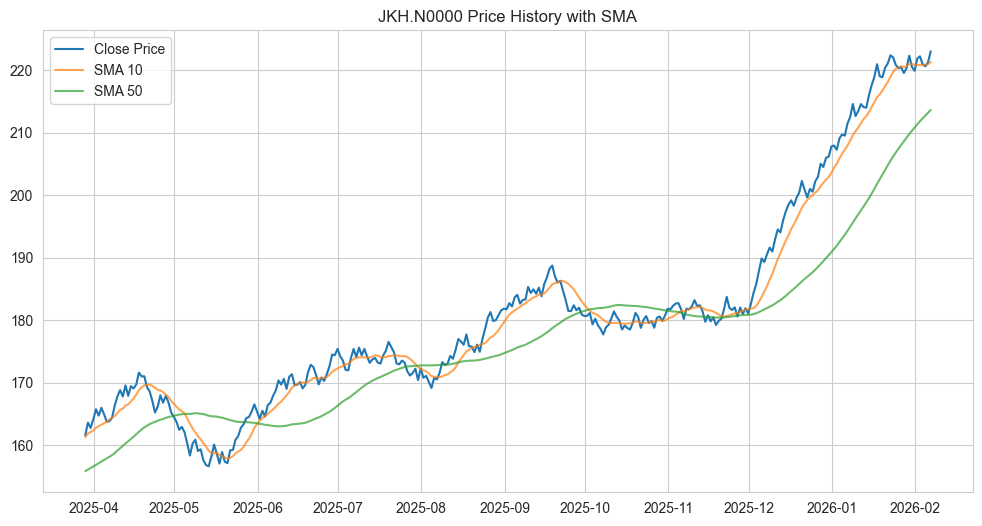

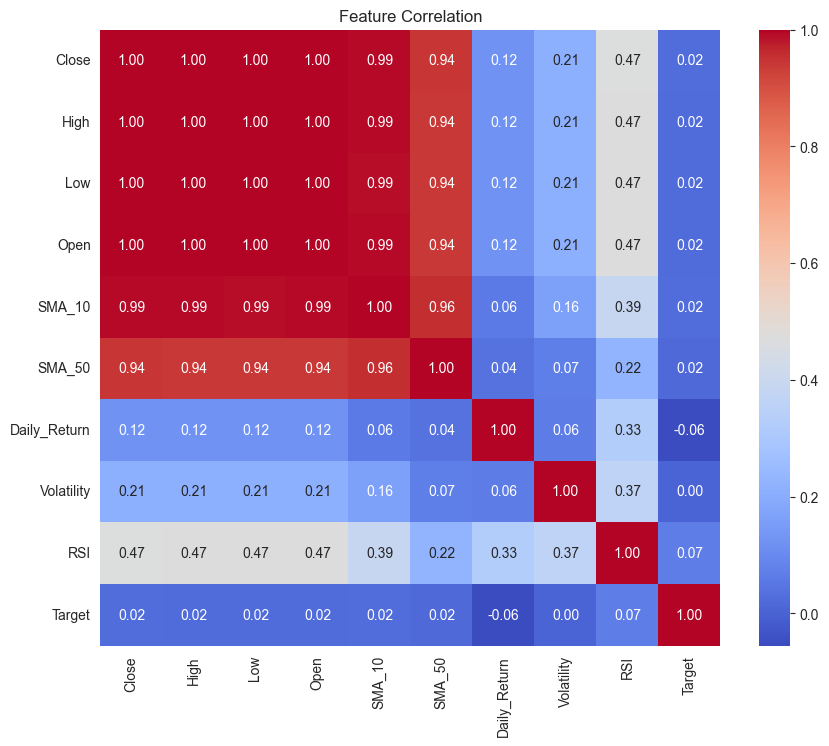

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_processed.index, df_processed['Close'], label='Close Price')
plt.plot(df_processed.index, df_processed['SMA_10'], label='SMA 10', alpha=0.7)
plt.plot(df_processed.index, df_processed['SMA_50'], label='SMA 50', alpha=0.7)
plt.title(f'{SYMBOL} Price History with SMA')
plt.legend()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

## 5. Model Training

In [33]:
# Features (X) and Target (y)
features = ['Close', 'SMA_10', 'SMA_50', 'Daily_Return', 'Volatility', 'RSI']
X = df_processed[features]
y = df_processed['Target']

# Split Data (Time Series Split - NOT random shuffle)
# We must train on PAST and test on FUTURE
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Data: {len(X_train)} rows")
print(f"Testing Data: {len(X_test)} rows")

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and Train Model
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
model.fit(X_train_scaled, y_train)

Training Data: 252 rows
Testing Data: 64 rows


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

## 6. Evaluation

Accuracy Score: 0.375

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.96      0.53        24
           1       0.50      0.03      0.05        40

    accuracy                           0.38        64
   macro avg       0.44      0.49      0.29        64
weighted avg       0.45      0.38      0.23        64



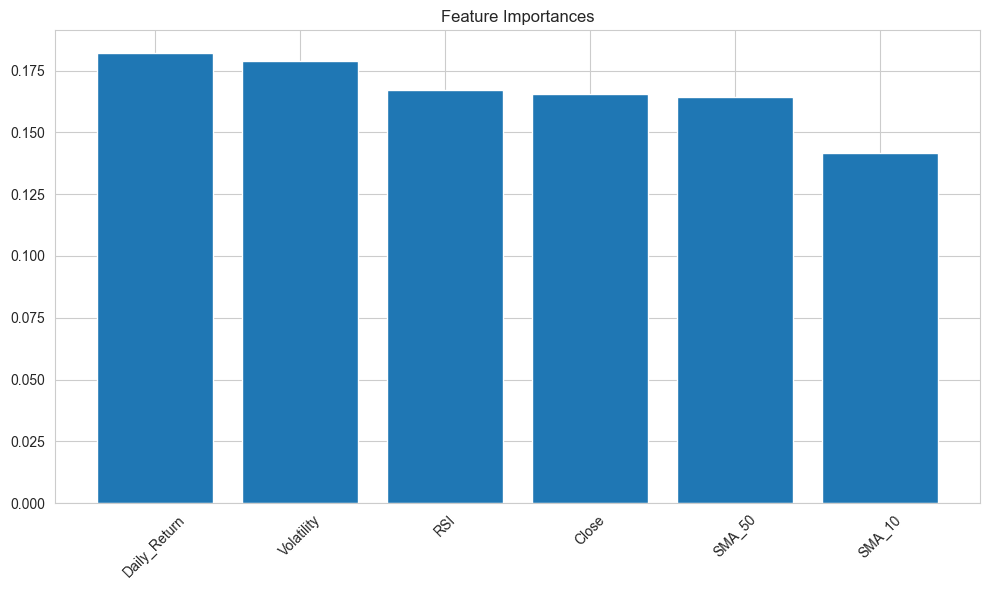

In [34]:
predictions = model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## 7. Real-Time Prediction
This function brings it all together: fetches the latest data, processes it, and predicts tomorrow's move.

In [35]:
def predict_next_move(symbol):
    print(f"Analyzing {symbol}...")
    try:
        # 1. Fetch Request
        df = fetch_stock_data(symbol)
        if df is None or len(df) < 50:
            return "Not enough data"
        
        # 2. Process
        df_tech = add_technical_indicators(df)
        
        # 3. Get latest row (Today)
        latest_data = df_tech.iloc[[-1]][features] # Double brackets to keep DataFrame format
        
        # 4. Scale
        latest_scaled = scaler.transform(latest_data)
        
        # 5. Predict
        prediction = model.predict(latest_scaled)[0]
        prob = model.predict_proba(latest_scaled)[0][prediction]
        
        move = "UP" if prediction == 1 else "DOWN"
        return f"Prediction for next trading day: {move} (Confidence: {prob:.2f})"
        
    except Exception as e:
        return f"Error: {str(e)}"

# Test Real-time Prediction
print(predict_next_move(SYMBOL))

Analyzing JKH.N0000...
Fetching data for JKH.N0000...
Prediction for next trading day: UP (Confidence: 0.57)
Prediction for next trading day: UP (Confidence: 0.57)
